# Выбор локации для скважины

Нам предоставлена информация о пробах нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Описание данных:
* *id* — уникальный идентификатор скважины;
* *f0*, *f1*, *f2* — три признака точек (неизвестно, что они означают, но сами признаки значимы);
* *product* — объём запасов в скважине (тыс. баррелей).

Детали, из которых исходим:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирем регион с наибольшей средней прибылью.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')
df = [df0, df1, df2]

In [3]:
for i in range(3):
    display(f'df{i}')
    df[i].info()
    display(df[i].head())
    display(df[i]['id'].value_counts().head())

'df0'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


fiKDv    2
TtcGQ    2
QcMuo    2
AGS9W    2
A5aEY    2
Name: id, dtype: int64

'df1'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


5ltQ6    2
LHZR0    2
bfPNe    2
wt4Uk    2
7lYuO    1
Name: id, dtype: int64

'df2'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Vcm5J    2
KUPhW    2
VF7Jo    2
xCHr8    2
88V4S    1
Name: id, dtype: int64

1. Видим, что типы данных правильные. 
2. Видим дубли в столбцах `id`, хотя это должны быть уникальные идентификаторы скважин, посмотрим на эти строки.

### Дубликаты в уникальных идентификаторах скважины

In [4]:
for i in range(3):
    display(f'df{i}')
    display('Количество дубликатов в датафрейме: ' + str(len(df[i][df[i]['id'].duplicated(keep=False)])))
    display(df[i][df[i]['id'].duplicated(keep=False)].sort_values(by='id').head())

'df0'

'Количество дубликатов в датафрейме: 20'

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


'df1'

'Количество дубликатов в датафрейме: 8'

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147


'df2'

'Количество дубликатов в датафрейме: 8'

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290


Видим, что это не полные дубли. Необходимо запросить уточнение по данным и понять, откуда берется дублирование уникальных идентификаторов. Можно предположить, что это пара старые/обновленные данные, но мы не знаем этого точно. Количество "проблемных" скважин невелико на фоне общего количества, удалим их из датафреймов.

In [5]:
for i in range(3):
    display(f'df{i}')
    df[i] = df[i].drop(df[i][df[i]['id'].duplicated(keep=False)].index)
    df[i].info()

'df0'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
id         99980 non-null object
f0         99980 non-null float64
f1         99980 non-null float64
f2         99980 non-null float64
product    99980 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


'df1'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
id         99992 non-null object
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64
product    99992 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


'df2'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
id         99992 non-null object
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64
product    99992 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Видим, что осталось правильное количество строк. Теперь можем удалить уникальные идентификаторы из дафафреймов.

In [6]:
for i in range(3):
    display(f'df{i}')
    df[i] = df[i].drop(columns='id')
    df[i].info()

'df0'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 4 columns):
f0         99980 non-null float64
f1         99980 non-null float64
f2         99980 non-null float64
product    99980 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


'df1'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 4 columns):
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64
product    99992 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


'df2'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 4 columns):
f0         99992 non-null float64
f1         99992 non-null float64
f2         99992 non-null float64
product    99992 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


### Распределения признаков 

In [7]:
df[0].columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

'df0'

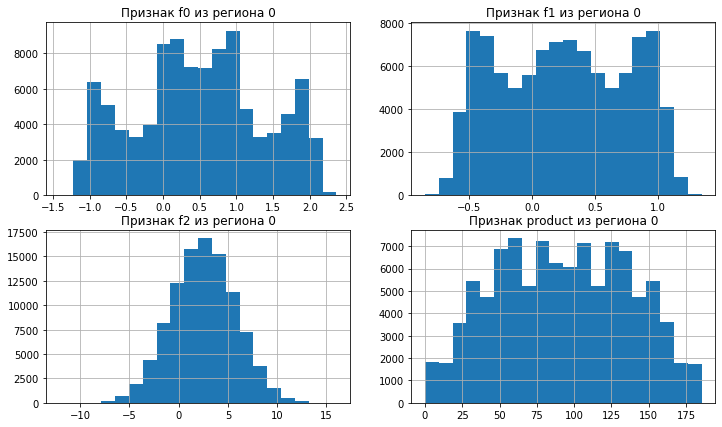

'df1'

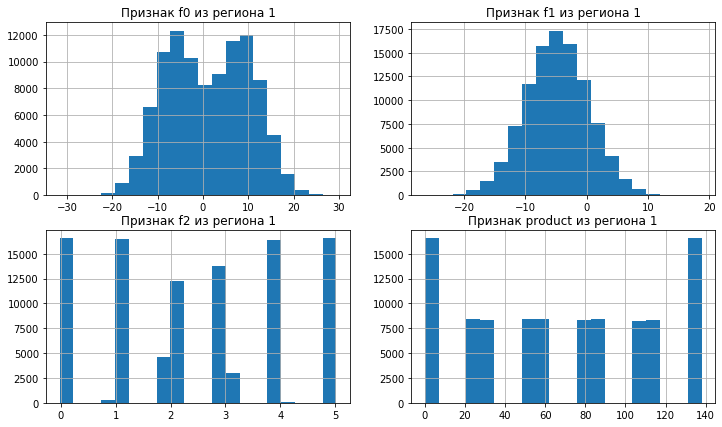

'df2'

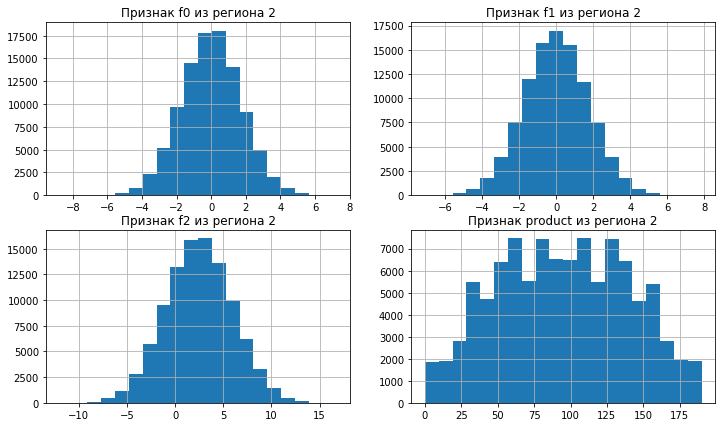

In [8]:
columns = ['f0', 'f1', 'f2', 'product']
for i in range(3):
    display(f'df{i}')
    plt.figure(figsize=(12, 7))
    j = 1
    for column in columns:    
        plt.subplot(2, 2, j)
        j += 1
        plt.hist(df[i][column], bins=20)
        plt.grid(True)
        plt.title('Признак ' + column + ' из региона ' + str(i))
    plt.show()

Обращаем внимание на то, что часть признаков имеет ненормальное распределение. 

### Корреляция признаков

<Figure size 432x288 with 0 Axes>

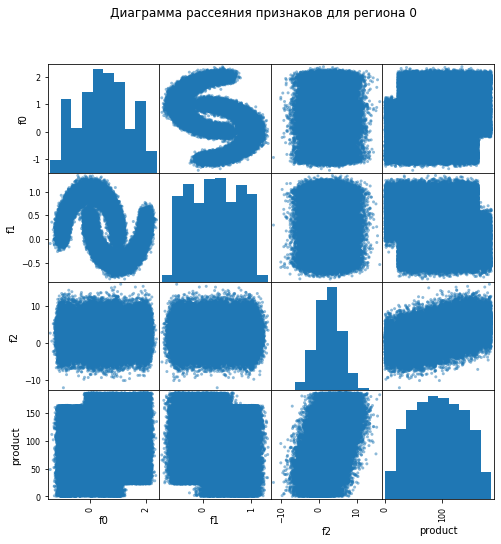

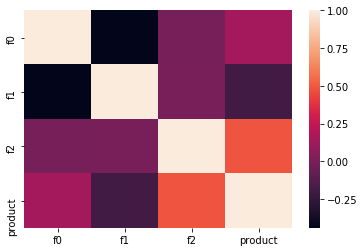

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


<Figure size 432x288 with 0 Axes>

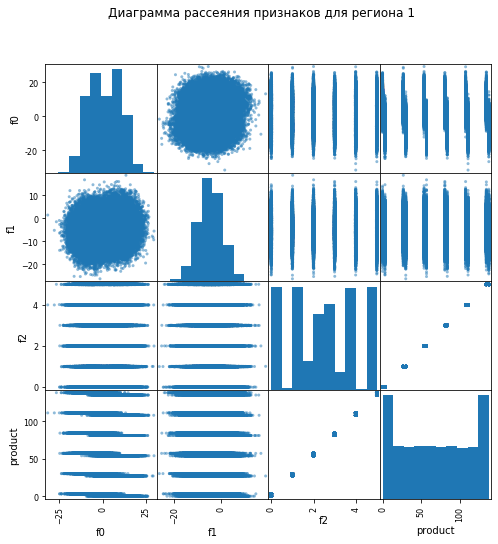

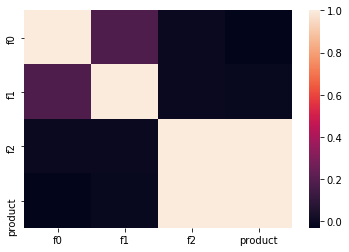

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


<Figure size 432x288 with 0 Axes>

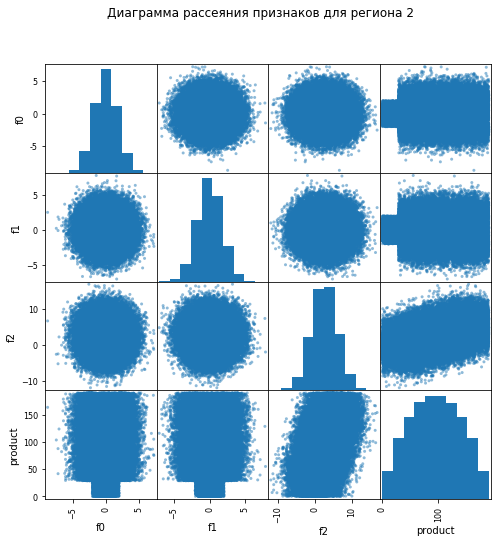

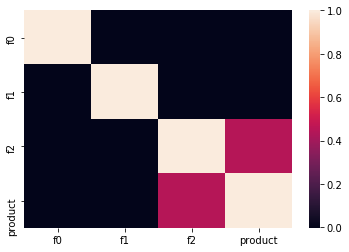

,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


In [9]:
for i in range(3):
    plt.figure()
    pd.plotting.scatter_matrix(df[i][columns], figsize=(8, 8), alpha=0.5)
    plt.suptitle('Диаграмма рассеяния признаков для региона ' + str(i))
    plt.show()
    sns.heatmap(df[i][columns].corr())
    plt.show()
    display(df[i][columns].corr())

Во всех трех случаях видим сильную корреляцию с признаком `f2`.

### Вывод

Мы работаем с тремя датасетами, содержащими информацию о скважинах в трех регионах нефтедобычи. По каждому региону нам была предоставлена информация о 10000 объектов: уникальный идентификатор `id`, три признака (`f0`, `f1`. `f2`), смысл которых нам неизвестен, и объем запасов в скважине `product`. 

1. В процессе знакомства с данными мы увидели, что не все идентификаторы скважин уникальных: в датасетах обнаружилось небольшое количество дублирований уникальных идентификаторов (8-20 в одном датасете из 10000 записей). Было принято решение удалить строки с неуникальными идентификаторами. 

2. Изучая признаки мы увидели, что не все значения распределены нормально. Приняли это во внимание.

3. Изучая корреляцию признаков увидели, что во всех трех регионах есть сильная корреляция целевого признака `product` с признаком `f2`. Обратили внимание на то, что диаграммаы рассеяния для некоторых пар признаков имеют экзотический вид (см. признаки `f0` и `f1` для региона **0**).

## Обучение и проверка модели

### Разбивка данных на train/valid


In [10]:
def features_target_train_valid_split(df, target_name='product', valid_size=0.25, random_state=42):
    df_train, df_valid = train_test_split(df, test_size=valid_size, 
                                               random_state=random_state)
    features_train = df_train.drop([target_name], axis=1)
    target_train = df_train[target_name]
    features_valid = df_valid.drop([target_name], axis=1)
    target_valid = df_valid[target_name]
    
    assert len(features_train) == len(target_train)
    assert len(features_valid) == len(target_valid)
    
    display('Размер исходной/обучающей/валидационной выборок')
    display(str(len(df)) + '/' + str(len(features_train)) + '/' + str(len(features_valid)))
    
    return features_train, target_train, features_valid, target_valid

In [11]:
features_train, target_train, features_valid, target_valid = [0]*3, [0]*3, [0]*3, [0]*3
for i in range(3):
    features_train[i], target_train[i], features_valid[i], target_valid[i] = features_target_train_valid_split(df[i])
    

'Размер исходной/обучающей/валидационной выборок'

'99980/74985/24995'

'Размер исходной/обучающей/валидационной выборок'

'99992/74994/24998'

'Размер исходной/обучающей/валидационной выборок'

'99992/74994/24998'

### Обучение моделей и предсказание запасов

In [12]:
def fit_predict(features_train, target_train, features_valid, target_valid, reg_title=''):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid))
    
    mean_pred = predictions.mean()
    display(f'Средний запас предсказанного сырья в регионе {reg_title} - ' 
            + str(round(mean_pred, 1)))
    
    rmse = mean_squared_error(target_valid, predictions)**0.5
    display('RMSE: ' + str(round(rmse, 2)))
    display('RMSE / средний запас: ' + str(rmse / mean_pred))
    
    return predictions

In [13]:
predictions = [0]*3
for i in range(3):
    predictions[i] = fit_predict(features_train[i], target_train[i], features_valid[i], target_valid[i], i)
    predictions[i].index = target_valid[i].index
    predictions[i] = pd.concat([target_valid[i], predictions[i]], axis=1)
    predictions[i].columns = ['y_true', 'y_pred']
    if i != 2:
        display('----------------')

'Средний запас предсказанного сырья в регионе 0 - 92.3'

'RMSE: 37.76'

'RMSE / средний запас: 0.4091728625924404'

'----------------'

'Средний запас предсказанного сырья в регионе 1 - 69.2'

'RMSE: 0.89'

'RMSE / средний запас: 0.012908446721640836'

'----------------'

'Средний запас предсказанного сырья в регионе 2 - 94.8'

'RMSE: 40.13'

'RMSE / средний запас: 0.42323205016904414'

### Вывод

Видим, что RMSE в **0** и **2** регионах достигает 40-42% от среднего предсказанного значения, в то время как в регионе **1** RMSE чуть больше 1% . При этом прогноз по запасу сырья в регионе 1 в 1.5 раза меньше, чем в регионах 0 и 2. 

## Подготовка к расчёту прибыли

In [14]:
n_to_check = 500 # при разведке исследуем 500 точек
n_to_choose = 200 # выбираем 200 лучших для разработки
price_per_region = 10 * 10 ** 9 # стоимость разработки скважин в регионе
price_per_well = price_per_region / n_to_choose # стоимость разработки скважины
price_per_barrel = 450 * 10 ** 3 # доход от 1 тыс. баррелей сырья
loss_prob = 0.025 # пороговое значение вероятности убытков - 2.5%

In [15]:
min_product = price_per_well / price_per_barrel
display(f'Минимальный запас сырья в скважине, необходимый для безубыточной разработки - {round(min_product, 2)}')

'Минимальный запас сырья в скважине, необходимый для безубыточной разработки - 111.11'

Видим, что полученная нами ранее оценка среднего запаса сырья в скважине по регионам (69-95) в меньше минимально необходимого запаса для безубыточной разработки. 

## Расчёт прибыли и рисков 

In [16]:
def profit_calculation(product_values):
    total_production = product_values.sort_values(by='y_pred', ascending=False)['y_true'].head(n_to_choose).sum()
    profit = total_production * price_per_barrel - price_per_well*n_to_choose
    return profit

In [17]:
state = np.random.RandomState(42)

In [18]:
bootstrap_results_pred = [[], [], []]
for i in range(3):
    display(f'Считаем регион {i}')
    for _ in tqdm(range(1000)):
        bootstrap_results_pred[i].append(profit_calculation(
            predictions[i].sample(n=500, random_state=state, replace=True))
                                   )
    bootstrap_results_pred[i] = pd.DataFrame(bootstrap_results_pred[i], columns=['profit'])

'Считаем регион 0'

  0%|          | 0/1000 [00:00<?, ?it/s]

'Считаем регион 1'

  0%|          | 0/1000 [00:00<?, ?it/s]

'Считаем регион 2'

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
bootstrap_results_pred_df = pd.DataFrame()
for i in range(3):
    bootstrap_results_pred_df = pd.concat([bootstrap_results_pred_df, bootstrap_results_pred[i]], axis=1)
bootstrap_results_pred_df.columns = ['profit reg_0', 'profit reg_1', 'profit reg_2']
bootstrap_results_pred_df   

,profit reg_0,profit reg_1,profit reg_2
0,6.352874e+08,3.628032e+08,4.795640e+08
1,1.055828e+08,1.388216e+08,7.840096e+08
2,-1.203615e+07,1.709167e+08,3.888578e+08
3,4.375085e+08,4.569737e+08,2.226416e+08
4,7.792898e+08,6.232339e+08,1.817752e+08
...,...,...,...
995,6.200461e+08,8.087760e+08,6.403141e+08
996,1.952338e+08,6.275257e+08,-4.857978e+07
997,3.329374e+08,3.735638e+08,7.845201e+08
998,2.302938e+08,5.319245e+08,-6.600234e+07


In [20]:
results_pred = pd.DataFrame(index=[0,1,2], columns=['mean_profit', '95%_lower_bound',
                                               '95%_upper_bound', 'loss_risk'])

# приводим к целочисленному типу, т.к. значения большие и погрешность будет пренебрежимо мала

for i in range(3):
    results_pred.loc[i, 'mean_profit'] = int(bootstrap_results_pred[i].mean())
    results_pred.loc[i, '95%_upper_bound'] = int(bootstrap_results_pred[i].quantile(0.975))
    results_pred.loc[i, '95%_lower_bound'] = int(bootstrap_results_pred[i].quantile(0.025))
    results_pred.loc[i, 'loss_risk'] = len(bootstrap_results_pred[i].query(
                                    'profit < 0')) / len(bootstrap_results_pred[i])

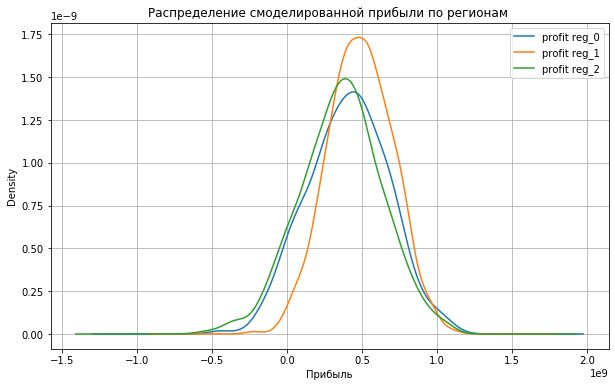

,mean_profit,95%_lower_bound,95%_upper_bound,loss_risk
1,489216525,68759710,908082704,0.009
0,405706852,-121426873,923795254,0.072
2,358879055,-184356014,890332669,0.096


In [21]:
bootstrap_results_pred_df.plot(kind='kde', grid=True, figsize=(10, 6))
plt.xlabel('Прибыль')
plt.title('Распределение смоделированной прибыли по регионам ')
plt.show()
results_pred.sort_values(by='mean_profit', ascending=False)

## Вывод

In [22]:
results_pred.sort_values(by='mean_profit', ascending=False)

,mean_profit,95%_lower_bound,95%_upper_bound,loss_risk
1,489216525,68759710,908082704,0.009
0,405706852,-121426873,923795254,0.072
2,358879055,-184356014,890332669,0.096



* Наше моделирование показывает, что ни в регионах **0** и **2** риск убытков превышает пороговые значения в 2.5%. 

* При этом регионы **0** и **2** имею больший средний запас сырья и высокий риск убытков, по всей видимости, может быть преодолен при использованнии более совершенной модели для предсказания объема сырья. Возможно, наша модель занижает запасы сырья на скважинах с большими запасами, что ведет к неоптимальному выбору скважин для разработки, увеличению риска убытков и снижению средней ожидаемой прибыли. Вероятно, использование нелинейной регрессии могло бы улучшить качество прогнозирования и, соответственно, целевые бизнес-метрики.

* Регион с наибольшей средней прибылью - **1** - имеет приемлемый риск убытков 1% и самую большую среднюю прибыль, именно его и стоит выбрать для разработки месторождений.
